In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# NLP Imports
import regex as re
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from sklearn.feature_extraction import text
from wordcloud import WordCloud, ImageColorGenerator
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# Other Imports
import janitor
from datetime import datetime
from dateutil import parser

stop_list = stopwords.words('english')
stop_list.extend([''])

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

In [4]:
chat = pd.read_csv('data/data_code/sample_1_cleaned.csv')

## Data Visualisation

In [5]:
party_names = chat['name'].unique().tolist()
party_names
party_1 = party_names[0]
party_2 = party_names[1]

In [6]:
msg_1 = chat[chat['name']==party_1]
msg_2 = chat[chat['name']==party_2]

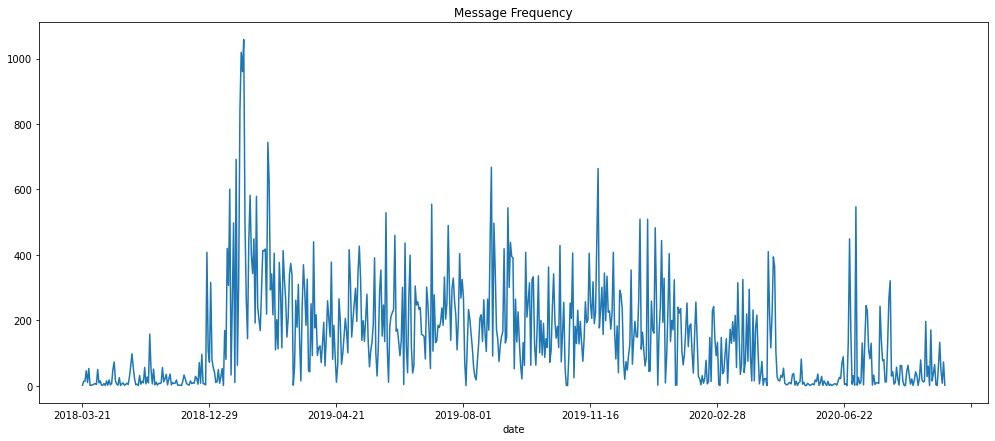

In [7]:
chat.groupby(['date']).count()['msg'].plot(figsize=(17,7),title=f'Message Frequency');

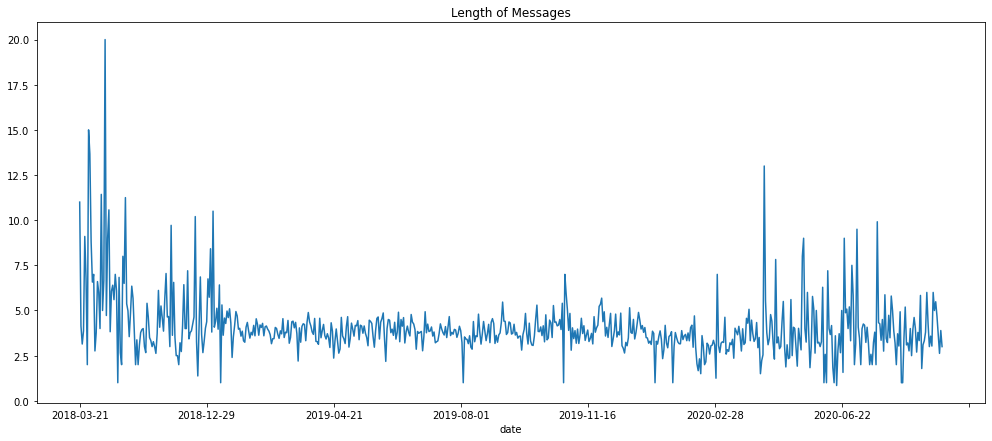

In [8]:
chat.groupby(['date'])['msg_len'].mean().plot(figsize=(17,7),title=f'Length of Messages');

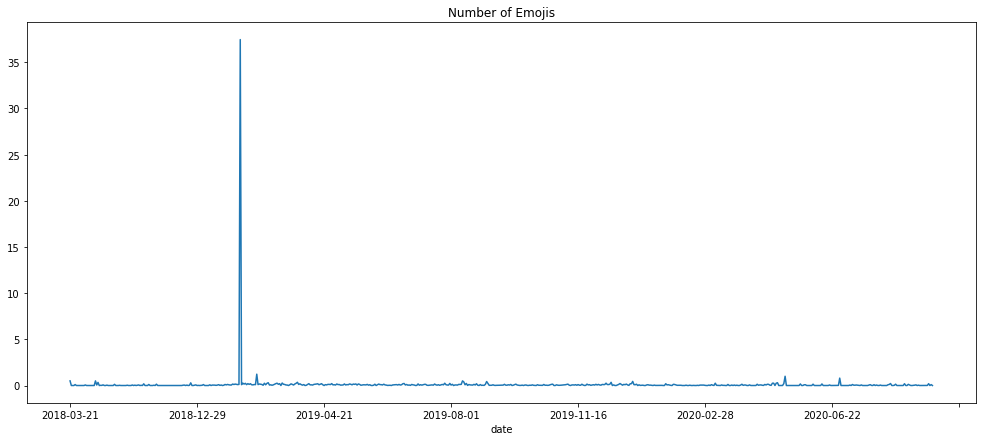

In [9]:
chat.groupby(['date'])['emoji_count'].mean().plot(figsize=(17,7),title=f'Number of Emojis');

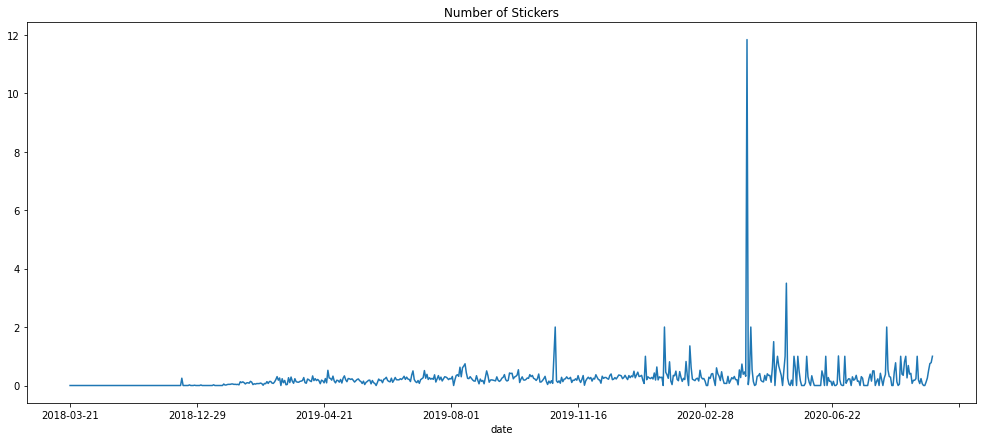

In [10]:
chat.groupby(['date'])['sticker_count'].mean().plot(figsize=(17,7),title=f'Number of Stickers');

In [11]:
def chat_filter_date(df):
    start_date = parser.parse(input("Enter start date: ") or str(df['date'].min()))
    end_date = parser.parse(input("Enter end date: ")or str(df['date'].max()))
    df_filtered = df.filter_date('date',start_date, end_date)[['date','name','msg']]
    return df_filtered.head(10)
def chat_filter_emoji(df):
    lower = int(input("Enter Emoji Lower Range: ") or 0)
    upper = int(input("Enter Emoji Upper Range: ") or df['emoji_count'].max())
    
    df_filtered = chat[(chat['emoji_count'] < upper) & (chat['emoji_count'] > lower)][['date','name','msg','emoji_count']].sort_values(by='emoji_count',ascending=False)
    return df_filtered.head(10)
def chat_filter_sticker(df):
    lower = int(input("Enter Sticker Lower Range: ") or 0)
    upper = int(input("Enter Sticker Upper Range: ") or df['sticker_count'].max())
    
    df_filtered = chat[(chat['sticker_count'] < upper) & (chat['sticker_count'] > lower)][['date','name','msg','sticker_count']].sort_values(by='sticker_count',ascending=False)
    return df_filtered.head(10)

In [12]:
def all_analysis(df):
    command = input('Please choose between date, emoji or sticker: ')
    if command == "emoji":
        return chat_filter_emoji(df)
    elif command == 'sticker':
        return chat_filter_sticker(df)
    elif command == 'date':
        return chat_filter_date(df)

In [13]:
all_analysis(chat)

Please choose between date, emoji or sticker: 


## Vectorizing 

In [14]:
cvec = CountVectorizer(stop_words = stops)

NameError: name 'stops' is not defined

### N-gram = 1

In [ ]:
cvec_msg = cvec.fit_transform(chat['msg_cleaned'])
cvec_msg = pd.DataFrame(cvec_msg.toarray(), columns = cvec.get_feature_names())

In [ ]:
cvec_msg_words = cvec_msg.sum().sort_values(ascending=False)
cvec_msg_words.head(10)

### N-gram = 2/3

In [ ]:
cvec23 = CountVectorizer(stop_words = stops,
                         ngram_range=(2,3),
                        max_features=10000)

In [ ]:
cvec_msg_23 = cvec23.fit_transform(chat['msg_cleaned'])
cvec_msg_23 = pd.DataFrame(cvec_msg_23.toarray(), columns = cvec23.get_feature_names())

In [ ]:
cvec_msg_words_23 = cvec_msg_23.sum().sort_values(ascending=False)
cvec_msg_words_23.head(10)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

msg_1 = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_msg_words) 

msg_23 = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(cvec_msg_words_23) 

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
ax[0].imshow(msg_1)
ax[1].imshow(msg_23)

ax[0].set_title('N-gram = 1',size=15)
ax[1].set_title('N-gram = 2/3',size=15)

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout(pad=5)

## Topical Analysis
#### 1. Preprocess Data

In [ ]:
def current_text_only(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

In [ ]:
data = chat['msg'].values.tolist()
print(data[42])

In [ ]:
data_words = list(current_text_only(data))
print (data_words[42])

#### Form Bigrams, Trigrams and Lemmatization

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
chat.shape

In [ ]:
def process_words(texts, stop_words=stop_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    j = 0   #instantiate counter
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if (j + 1) % 10000 == 0:
            print(f'Conversation Number {j + 1} of 99,377.')
        j += 1
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]   
    return texts_out

In [ ]:
def process_words_bitri(texts, stop_words=stop_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    j = 0   #instantiate counter
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if (j + 1) % 10000 == 0:
            print(f'Conversation Number {j + 1} of 99,377.')
        j += 1
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]   
    return texts_out

In [ ]:
data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
data_ready_bitri = process_words_bitri(data_words)  # processed Text Data!

#### 2. Understanding Text Clusters

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
id2word_bitri = corpora.Dictionary(data_ready_bitri)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus_bitri = [id2word.doc2bow(text) for text in data_ready_bitri]

# Build LDA model for all single words and bi-tri-grams:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [ ]:
lda_model_bitri = gensim.models.ldamodel.LdaModel(corpus=corpus_bitri,
                                           id2word=id2word_bitri,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())

In [ ]:
print(lda_model_bitri.print_topics())

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
df_dominant_topic.shape

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

In [ ]:
# 1. Wordcloud of Top 50 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

In [ ]:
df_dominant_topic.to_csv('data/data_code/dominant_topic_1.csv', index = False)

#### 3. Analysis of Chat Data

In [15]:
chat_topic = chat[['msg']].join(df_dominant_topic)
chat_topic.columns = map(str.lower, chat_topic.columns)
chat_topic.head()

NameError: name 'df_dominant_topic' is not defined

In [16]:
chat_topic['dominant_topic'].value_counts()

NameError: name 'chat_topic' is not defined